### 네이버 영화 평점 리뷰 데이터 노트북

#### 읽어오기

In [1]:
import wget

wget.download('https://github.com/e9t/nsmc/raw/master/ratings_train.txt', out='data')
wget.download('https://github.com/e9t/nsmc/raw/master/ratings_test.txt', out='data')

'data/ratings_test (1).txt'

In [2]:
import pandas as pd

train = pd.read_csv('data/ratings_train.txt', sep='\t')
test = pd.read_csv('data/ratings_test.txt', sep='\t')

# 필요없는 열은 drop
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

#### Null 값 제거하기

In [3]:
# null 개수 확인
print(f'trainset null 개수:\n{train.isnull().sum()}\n')
print(f'testset null 개수:\n{test.isnull().sum()}')

trainset null 개수:
document    5
label       0
dtype: int64

testset null 개수:
document    3
label       0
dtype: int64


In [4]:
train.dropna(inplace=True)
test.dropna(inplace=True)

#### 중복 제거하기

In [5]:
print(f'중복 제거 전 train length: {len(train)}')
train.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
print(f'중복 제거 후 train length: {len(train)}\n')
print(f'중복 제거 전 test length: {len(test)}')
test.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
print(f'중복 제거 후 test length: {len(test)}\n')

중복 제거 전 train length: 149995
중복 제거 후 train length: 146182

중복 제거 전 test length: 49997
중복 제거 후 test length: 49157



#### 전체 데이터 label 분포 확인하기

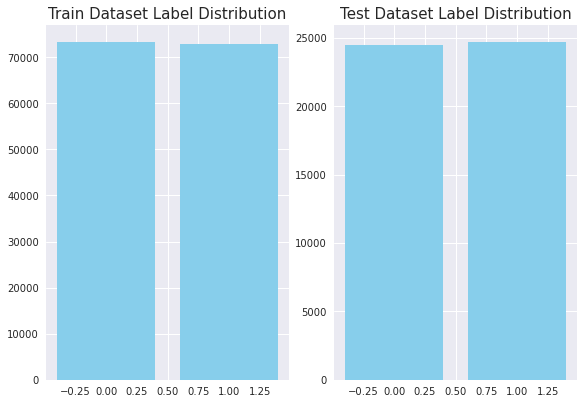

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

train_vlcnt = train['label'].value_counts().reset_index()
test_vlcnt = test['label'].value_counts().reset_index()

plt.subplots(constrained_layout=True)

plt.subplot(1, 2, 1)
plt.title('Train Dataset Label Distribution', fontsize=15)
plt.bar(train_vlcnt['index'], train_vlcnt['label'], color='skyblue')

plt.subplot(1, 2, 2)
plt.title('Test Dataset Label Distribution', fontsize=15)
plt.bar(test_vlcnt['index'], test_vlcnt['label'], color='skyblue')

plt.show()

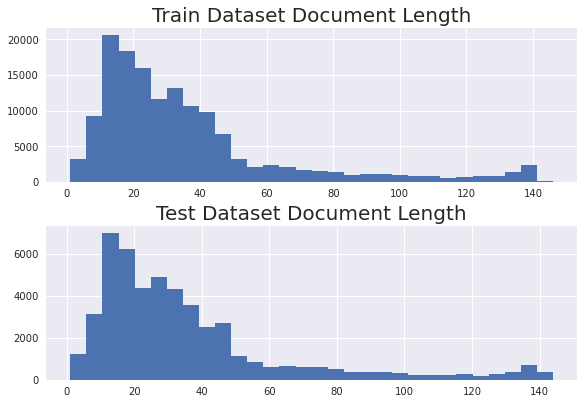

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

train_doc_len = [len(x) for x in train['document']]
test_doc_len = [len(x) for x in test['document']]

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('Train Dataset Document Length', fontsize=20)
plt.hist(train_doc_len, bins=30)

plt.subplot(2, 1, 2)
plt.title('Test Dataset Document Length', fontsize=20)
plt.hist(test_doc_len, bins=30)

plt.show()

#### 정규표현식으로 한국어만 남기기

In [8]:
import re
from tqdm import tqdm

def removing_non_korean(df):
    for idx, row in tqdm(df.iterrows(), desc='removing_non_korean', total=len(df)):
        new_doc = re.sub('[^가-힣]', '', row['document']).strip()
        df.loc[idx, 'document'] = new_doc
    return df

In [9]:
train = removing_non_korean(train)
test = removing_non_korean(test)

removing_non_korean: 100%|██████████| 49157/49157 [00:07<00:00, 6221.34it/s]


#### 조사 제거하지 않은 데이터 저장

In [10]:
train.to_csv('data/train_none.csv', index=False)
test.to_csv('data/test_none.csv', index=False)

#### 조사 제거하기

In [11]:
tags = ['JK', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']

In [12]:
from konlpy.tag import Mecab

m = Mecab()

def remove_josa_mecab(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing josa', total=len(df)):
        josa_removed = [x[0] for x in m.pos(row['document']) if x[1] not in tags]
        df.loc[idx, 'document'] = ' '.join(josa_removed)
    return df

train_mecab = remove_josa_mecab(train, tags)
test_mecab = remove_josa_mecab(test, tags)

removing josa: 100%|██████████| 49157/49157 [00:12<00:00, 3925.97it/s]


In [13]:
from konlpy.tag import Komoran

k = Komoran()

def remove_josa_komoran(df, tags):
    for idx, row in tqdm(df.iterrows(), desc='removing josa', total=len(df)):
        josa_removed = [x[0] for x in k.pos(row['document']) if x[1] not in tags]
        df.loc[idx, 'document'] = ' '.join(josa_removed)
    return df

train_komoran = remove_josa_komoran(train, tags)
test_komoran = remove_josa_komoran(test, tags)

removing josa: 100%|██████████| 49157/49157 [00:38<00:00, 1292.33it/s]


#### label 분포 확인하기

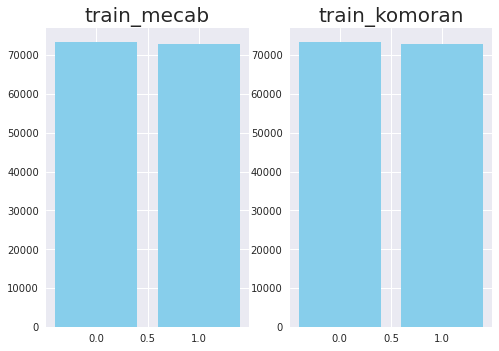

In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

train_mecab_vlcnt = train_mecab['label'].value_counts().reset_index()
train_komoran_vlcnt = train_komoran['label'].value_counts().reset_index()

plt.subplot(1, 2, 1)
plt.title('train_mecab', fontsize=20)
plt.bar(train_mecab_vlcnt['index'], train_mecab_vlcnt['label'], color='skyblue')

plt.subplot(1, 2, 2)
plt.title('train_komoran', fontsize=20)
plt.bar(train_komoran_vlcnt['index'], train_komoran_vlcnt['label'], color='skyblue')

plt.show()

#### document 데이터 길이 확인해보기

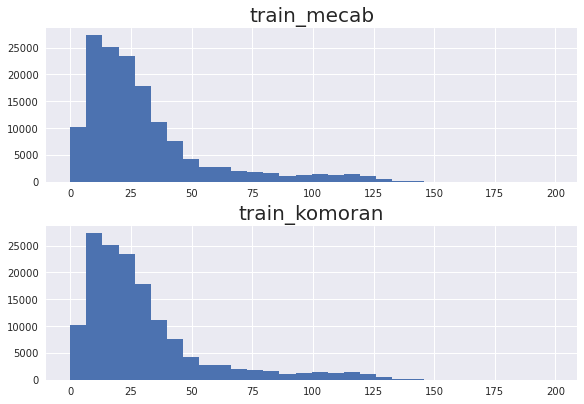

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

train_mecab_doc_len = [len(x) for x in train_mecab['document']]
train_komoran_doc_len = [len(x) for x in train_komoran['document']]

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('train_mecab', fontsize=20)
plt.hist(train_mecab_doc_len, bins=30)

plt.subplot(2, 1, 2)
plt.title('train_komoran', fontsize=20)
plt.hist(train_komoran_doc_len, bins=30)

plt.show()

#### 전처리 완료 데이터 저장하기

In [16]:
train_mecab.to_csv('data/train_mecab.csv', index=False)
test_mecab.to_csv('data/test_mecab.csv', index=False)

train_komoran.to_csv('data/train_komoran.csv', index=False)
test_komoran.to_csv('data/test_komoran.csv', index=False)